In [74]:
%load_ext autoreload 
%autoreload 1
%aimport models, utils
from importlib import reload
reload(models.contrastive)
reload(utils.plot)
reload(utils.linear)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'utils.linear' from '/home/theo/Documents/TCC-EEG/utils/linear.py'>

In [75]:
import mne
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018
from braindecode.datasets.base import BaseConcatDataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skorch.callbacks import EpochScoring, ProgressBar
from skorch.helper import predefined_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import torch

from utils.datasets import get_sleep_physionet, split_dataset, list_of_train_sets, TimeContrastiveDataset
from utils.skorch import EEGTransformer
from utils.linear import plot_knn, plot_knn_noise, compute_dist_to_knn
from utils.plot import (sleep_cmap, rand_cmap, plot_embeddings, get_ages, get_sleep_stages, get_subjects, get_recording, get_sex)
from models.contrastive import ContrastiveModule, EncoderNet, ClassifierNet, train_and_test

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
%%capture
# full dataset, to get a small one, use: get_sleep_physionet(range(10))
windows_dataset, info = get_sleep_physionet()

In [4]:
self_train_set, self_valid_set, full_train_set, valid_set, test_set, subjects_dic = split_dataset(windows_dataset)
print(len(self_train_set), len(self_valid_set), len(full_train_set), len(valid_set), len(test_set))

115813 17622 133435 16156 18058


In [5]:
splitted = windows_dataset.split('subject')
all_valid_set = TimeContrastiveDataset([splitted[s] for s in subjects_dic['self_valid_subjects'] + subjects_dic['valid_subjects']], delta_index_positive=5, delta_index_negative=20)

In [14]:
sleep_stages = get_sleep_stages(all_valid_set)
ages = get_ages(all_valid_set, info)
subjects = get_subjects(all_valid_set)
recording = get_recording(all_valid_set)
sex = get_sex(all_valid_set, info)

In [15]:
new_cmap = rand_cmap(max(subjects)+1, type='bright', first_color_black=True,
                     last_color_black=False, verbose=False)

mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 4': 3,
    'Sleep stage 3': 3,
    'Sleep stage R': 4
}
reverse_mapping = {v: k[-1] for k,v in mapping.items()}

# Training

In [16]:
def make_random_gaussian(mean, cov, same=False):
    def random_gaussian(X, y):
        """
        X (2, channels, time)
        y int
        """
        if same == 'label':
            if y:
                #Same noise
                noise = np.random.multivariate_normal(mean, cov, size=X.shape[-1]).T
                noise = np.tile(noise,(2,1,1))
            else:
                #Different noise
                noise = np.random.multivariate_normal(mean, cov, size=(2, X.shape[-1])).transpose(0,2,1)
        if same:
            #Same noise
            noise = np.random.multivariate_normal(mean, cov, size=X.shape[-1]).T
            noise = np.tile(noise,(2,1,1))
        else:
            #Different noise
            noise = np.random.multivariate_normal(mean, cov, size=(2, X.shape[-1])).transpose(0,2,1)
        return X + noise
    return random_gaussian

In [ ]:
mean = [0.,0.]
cov = [[0.1, 0.], [0., 0.1]]
self_train_set.transform = make_random_gaussian(mean, cov, same='label')
self_train_set[0]

In [7]:
n_channels = 2
p_dropout = 0.2
window_size = 30
sfreq = 100

lr = 5e-4
batch_size = 100
max_nb_epochs = 20
early_stopping_patience = 5

networks, skorch_nets = [], []

path = './experiences/noise/'#'/mnt/285EDDF95EDDC02C/Users/Public/Documents/TCC-EEG/nb_patients/'

noise_levels = [0., 0.1, 0.2, 0.4, 0.8, 1.6]
same = False

for i, noise in enumerate(noise_levels):
    encoder = SleepStagerChambon2018(
        n_channels,
        sfreq,
        n_classes=128,
        n_conv_chs=16,
        input_size_s=window_size,
        dropout=p_dropout,
    )
    encoder.num_features = 128
    network = ContrastiveModule(encoder)
    
    name = 'contrastive_network_noise_{}'.format(i)
    
    if os.path.isfile(path + name + '.pkl'):
        print('Loading: ', i)
        #network.load_state_dict(torch.load('./experiences/nb_patients/contrastive_network_{}.pt'.format(nb_subject)))
        with open(path + name + '.pkl', 'rb') as f:
            skorch_net = pickle.load(f)
        network = skorch_net.module_
    else:
        mean = [0.,0.]
        cov = [[noise, 0.], [0., noise]]
        self_train_set.transform = make_random_gaussian(mean, cov, same=same)
        print('Training: ', i)
        skorch_net = network.train_(
            self_train_set, self_valid_set, lr=lr, batch_size=batch_size,
            max_nb_epochs=max_nb_epochs, early_stopping_patience=early_stopping_patience)
        torch.save(network.state_dict(), path + name + '.pt')
        with open(path + name + '.pkl', 'wb') as f:
            pickle.dump(skorch_net, f)
    networks.append(network)
    skorch_nets.append(skorch_net)

Loading:  0
Loading:  1
Loading:  2
Loading:  3
Loading:  4
Loading:  5


# Embeddings

In [8]:
# Embeddings
embds_list = [skorch_net.transform(all_valid_set)[::2] for skorch_net in tqdm(skorch_nets)]

In [66]:
# PCA
pca_list = [PCA(2) for _ in range(len(embds_list))]
pca_embds_list = [pca.fit_transform(embds) for pca, embds in tqdm(zip(pca_list, embds_list), total=len(embds_list))]
# TSNE
tsne_list = [TSNE(2, n_jobs=-1) for _ in range(len(embds_list))]
tsne_embds_list = [tsne.fit_transform(embds) for tsne, embds in tqdm(zip(tsne_list, embds_list), total=len(embds_list))]

In [9]:
self_train_set.transform = None

train_embds_list = [skorch_net.transform(self_train_set)[::2] for skorch_net in tqdm(skorch_nets)]
train_subjects = get_subjects(self_train_set)
train_recording = get_recording(self_train_set)
train_sleep_stages = get_sleep_stages(self_train_set)
train_ages_per_subject = [info[info['subject'] == subject_id]['age'].iloc[0] for subject_id in np.unique(train_subjects)]

In [10]:
list_1, list_2 = [], []
for train_embds in train_embds_list:
    dist_list_1 = []
    dist_list_2 = []
    dist_list_all = []
    for subject_id in tqdm(np.unique(train_subjects), leave=False):
        distances_1 = compute_dist_to_knn(train_embds[(train_subjects==subject_id) & (train_recording == 1)], k='auto')
        dist_list_1.append(np.mean(distances_1))

        distances_2 = compute_dist_to_knn(train_embds[(train_subjects==subject_id) & (train_recording == 2)], k='auto')
        dist_list_2.append(np.mean(distances_2))
        dist_list_all.append(np.concatenate([distances_1, distances_2]))
    dist_list_1 = np.array(dist_list_1)
    dist_list_2 = np.array(dist_list_2)
    dist_list_all = np.array([np.mean(x) for x in dist_list_all])
    
    list_1.append(dist_list_1)
    list_2.append(dist_list_2)

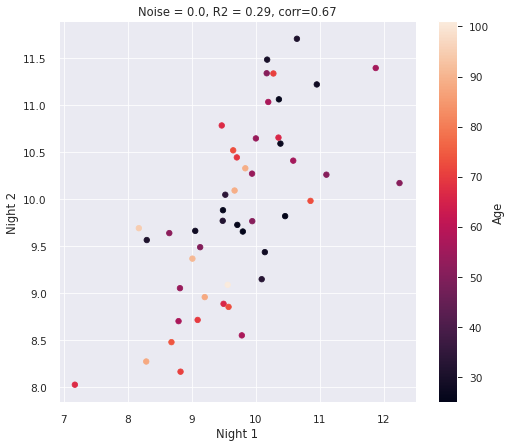

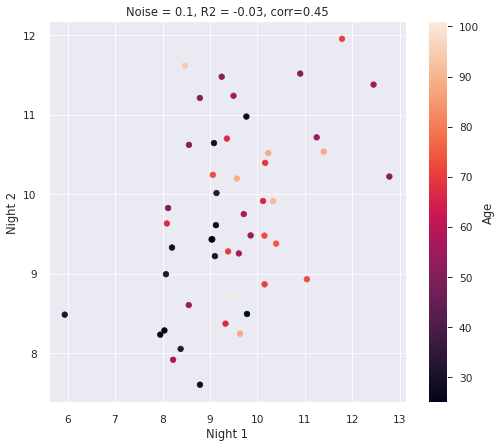

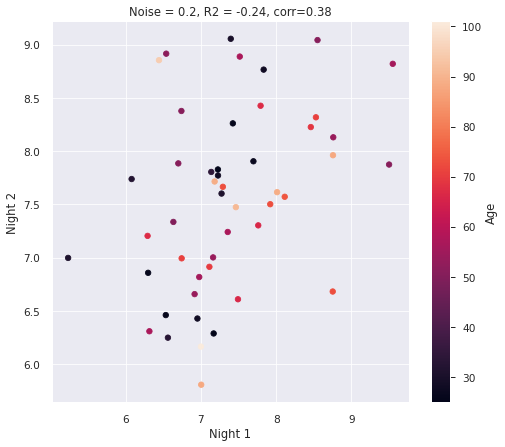

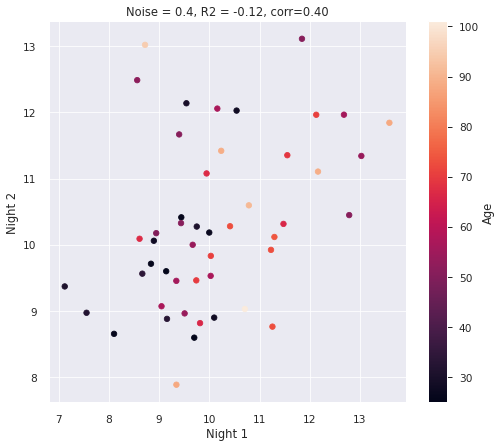

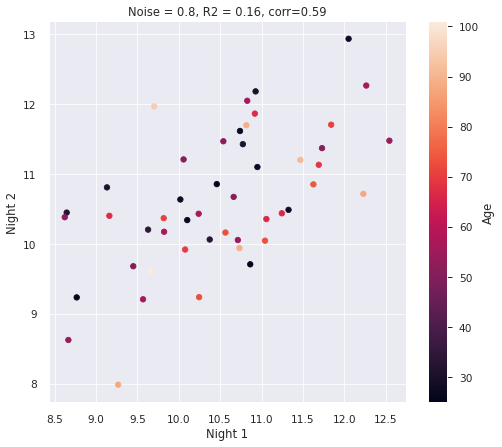

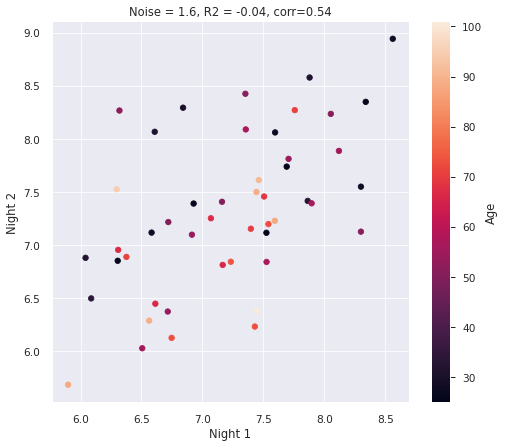

In [12]:
for dist_list_1, dist_list_2, noise in zip(list_1, list_2, noise_levels):
    plt.figure()
    plt.scatter(dist_list_1, dist_list_2, c=train_ages_per_subject, s=30)
    plt.xlabel('Night 1')
    plt.ylabel('Night 2')
    plt.title('Noise = {}, R2 = {:0.2f}, corr={:0.2f}'.format(noise,
                                                              r2_score(dist_list_1, dist_list_2),
                                                              np.corrcoef(dist_list_1, dist_list_2)[0,1]))
    cbar = plt.colorbar()
    cbar.set_label('Age')
#plt.savefig('img/mean_dist.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))

100%|██████████| 6/6 [04:55<00:00, 49.29s/it]


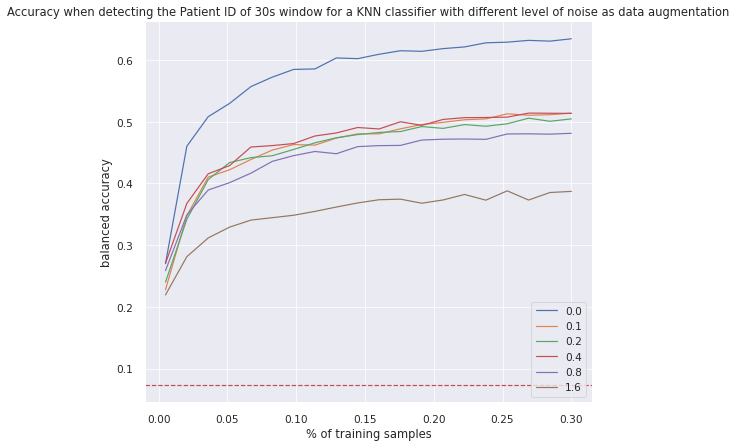

In [67]:
plot_knn(embds_list, subjects, colorbar=False, verbose=1)
plt.legend(noise_levels, loc='lower right')
plt.savefig('img/knn_benchmark_patient_noise.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title('Accuracy when detecting the Patient ID of 30s window for a KNN classifier with different level of noise as data augmentation');

100%|██████████| 6/6 [05:01<00:00, 50.19s/it]


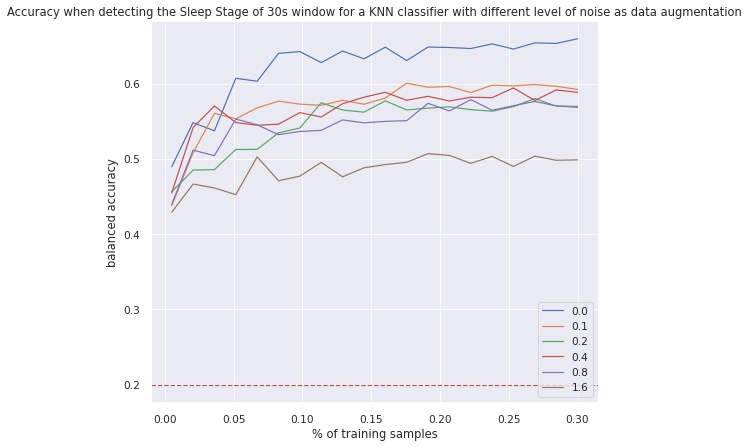

In [68]:
plot_knn(embds_list, sleep_stages, colorbar=False, verbose=1)
plt.legend(noise_levels, loc='lower right')
plt.savefig('img/knn_benchmark_sleep_noise.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title('Accuracy when detecting the Sleep Stage of 30s window for a KNN classifier with different level of noise as data augmentation');

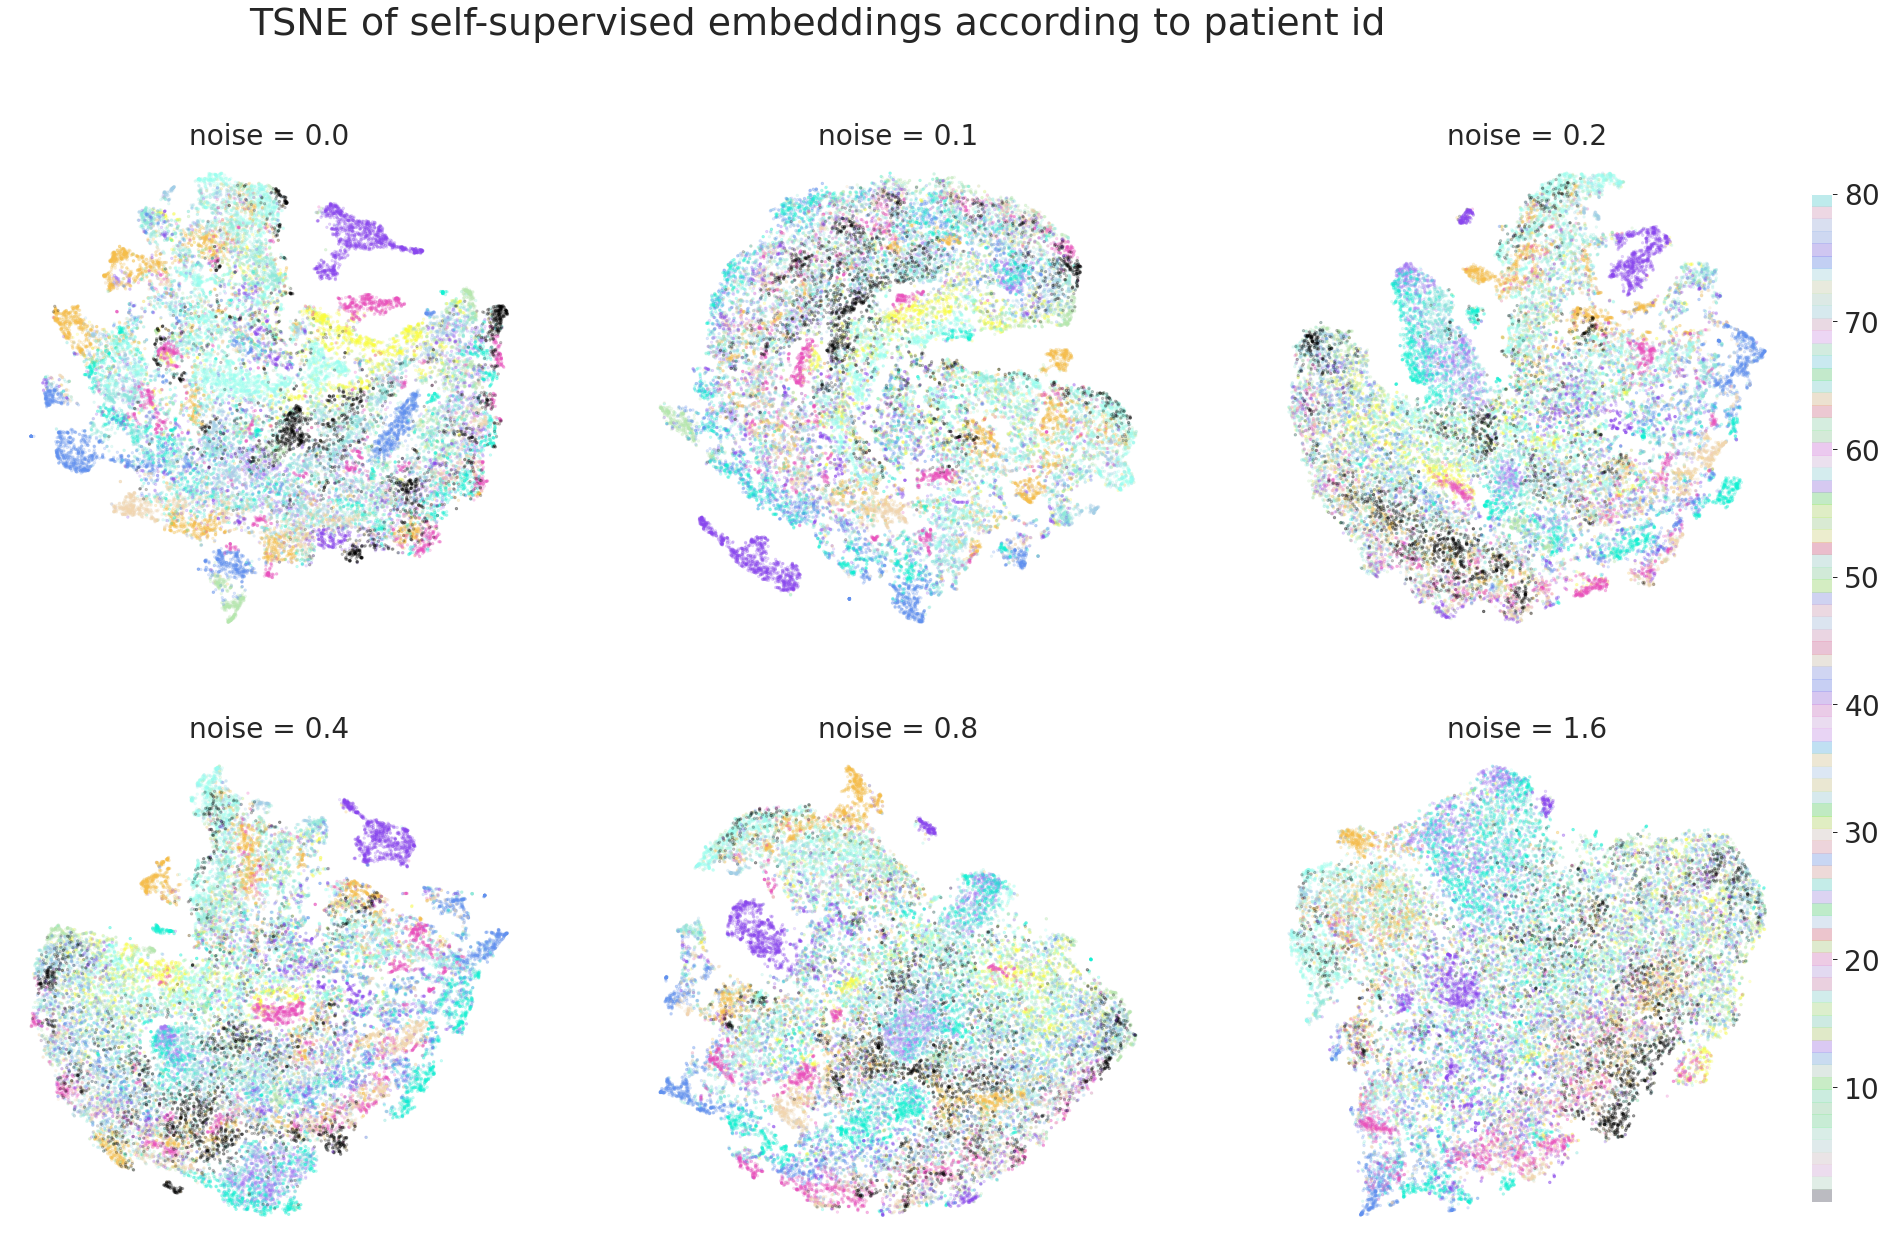

In [81]:
fig = plt.figure(figsize=(30,20))
for i, tsne_embds in enumerate(tsne_embds_list):
    plt.subplot(2,3,i+1)
    im = plot_embeddings(tsne_embds, subjects, new_cmap, alpha=0.2, colorbar=False)
    plt.title("noise = {}".format(noise_levels[i]), fontsize=28)

# Put colorbar to the right
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=28)

plt.savefig('img/patient_id_per_noise_tsne.png', dpi=50, bbox_inches='tight', pad_inches=0, transparent=True)
plt.suptitle('TSNE of self-supervised embeddings according to patient id', fontsize=38);

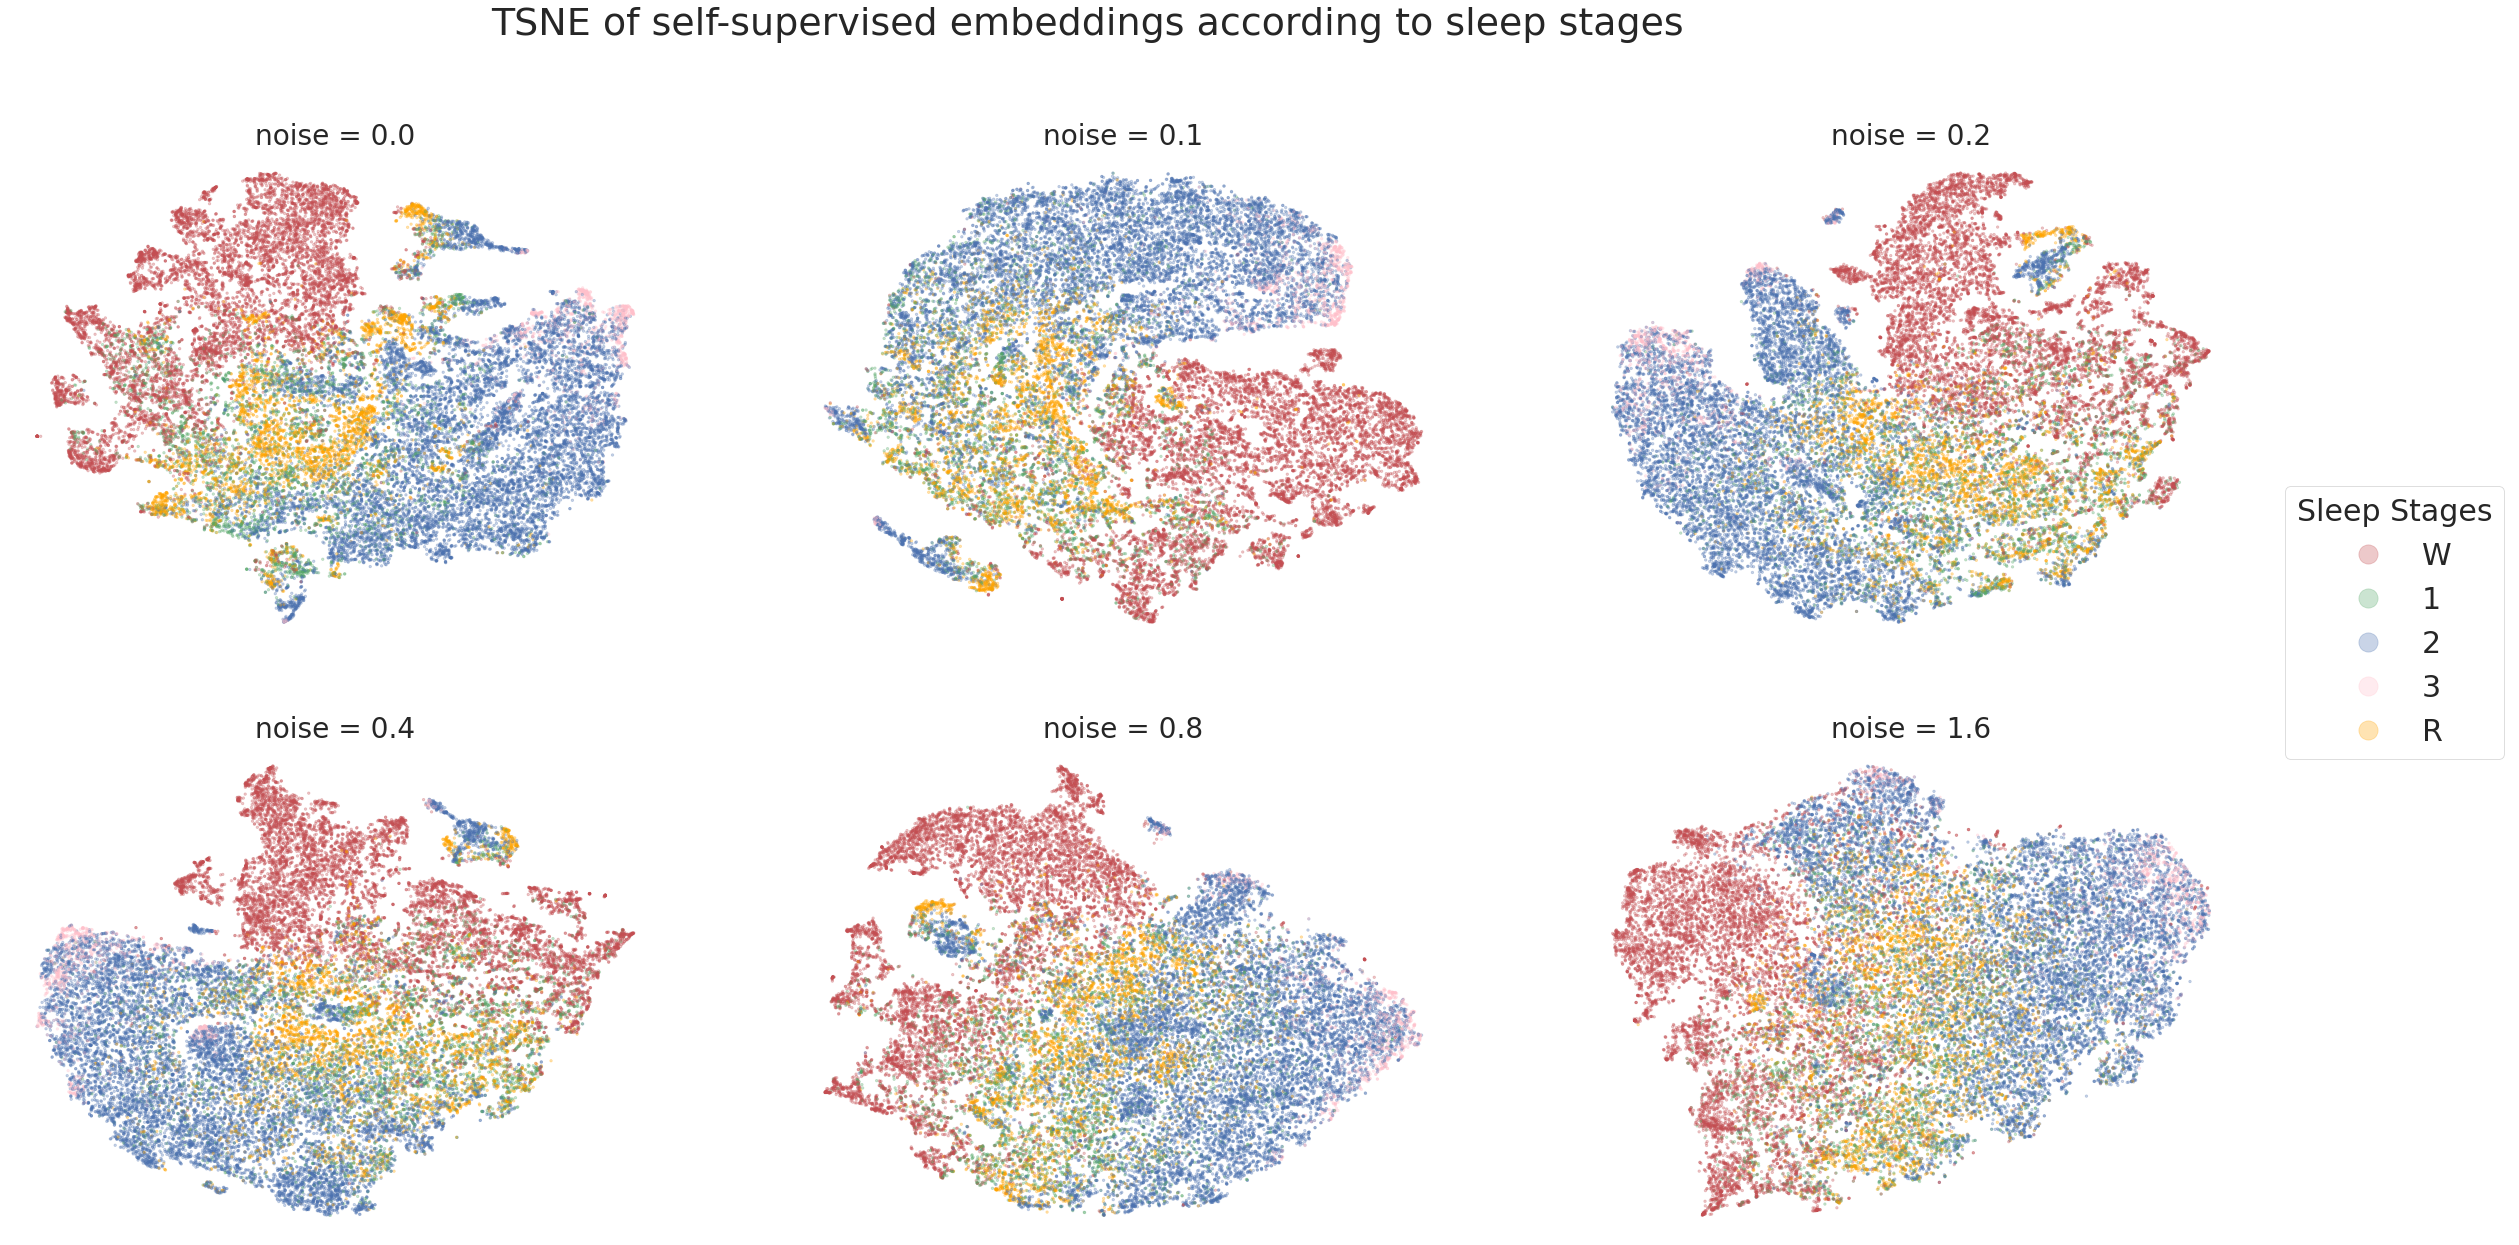

In [82]:
fig = plt.figure(figsize=(40,20))
for i, tsne_embds in enumerate(tsne_embds_list):
    plt.subplot(2,3,i+1)
    im = plot_embeddings(tsne_embds, sleep_stages, sleep_cmap, colorbar=False)
    plt.title("noise = {}".format(noise_levels[i]), fontsize=28)

# Add legend to the right
legend = fig.legend(*im.legend_elements(prop="colors"),
                    loc="right", title='Sleep Stages', markerscale=4., fontsize=30, title_fontsize=30, facecolor='None')
for i in range(len(legend.get_texts())):
    legend.get_texts()[i].set_text(reverse_mapping[i])

plt.savefig('img/sleep_stages_per_noise_tsne.png', dpi=50, bbox_inches='tight', pad_inches=0, transparent=True)
plt.suptitle("TSNE of self-supervised embeddings according to sleep stages", fontsize=38);

In [110]:
from sklearn.preprocessing import normalize
dist_list = []
for embds in tqdm(embds_list):
    dist_list_subjects = []
    embds_norm = (embds - embds.min(0)) / (embds.max(0)-embds.min(0))
    #embds_norm = (embds - embds.mean(0)) / (np.std(embds, 0) + (np.std(embds, 0)==0).astype(np.float32))
    #embds_norm = normalize(embds, norm='l2')
    for subject_id in np.unique(subjects):
        distances = compute_dist_to_knn(embds_norm[subjects==subject_id], k='auto')
        dist_list_subjects.append(np.mean(distances))
    dist_list.append(dist_list_subjects)
dist_list = np.array(dist_list)

Text(0, 0.5, 'Mean distance to k-nn for each patient')

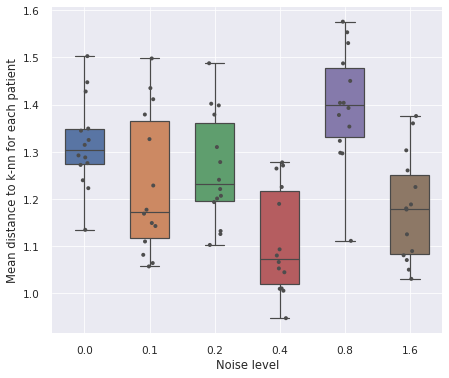

In [111]:
f, ax = plt.subplots(figsize=(7, 6))

sns.boxplot(x=np.repeat(noise_levels, len(np.unique(subjects))), y=dist_list.flatten(),
            whis=[0, 100], width=.6)
sns.stripplot(x=np.repeat(noise_levels, len(np.unique(subjects))), y=dist_list.flatten(),
              size=4, color=".3", linewidth=0)

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
plt.xlabel("Noise level")
plt.ylabel("Mean distance to k-nn for each patient")
#plt.savefig('img/mean_dist_per_sleep.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))

In [38]:
noise_embds_list = []
for noise in noise_levels:
    mean = [0.,0.]
    cov = [[noise, 0.], [0., noise]]
    all_valid_set.transform = make_random_gaussian(mean, cov, same=same)
    noise_embds_list.append([skorch_net.transform(all_valid_set)[::2] for skorch_net in tqdm(skorch_nets)])
all_valid_set.transform = None
noise_embds_list = np.array(noise_embds_list).transpose(1,0,2,3)

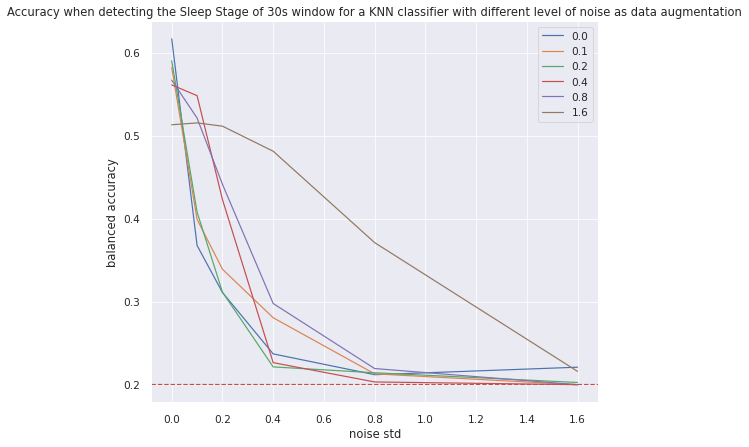

In [57]:
plot_knn_noise(train_embds_list, train_sleep_stages, noise_embds_list, sleep_stages, noise_levels, percentage_train=0.3, colorbar=False, verbose=1)
plt.legend(noise_levels, loc='upper right')
plt.savefig('img/knn_benchmark_sleep_noise_noise.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title('Accuracy when detecting the Sleep Stage of 30s window for a KNN classifier with different level of noise as data augmentation');

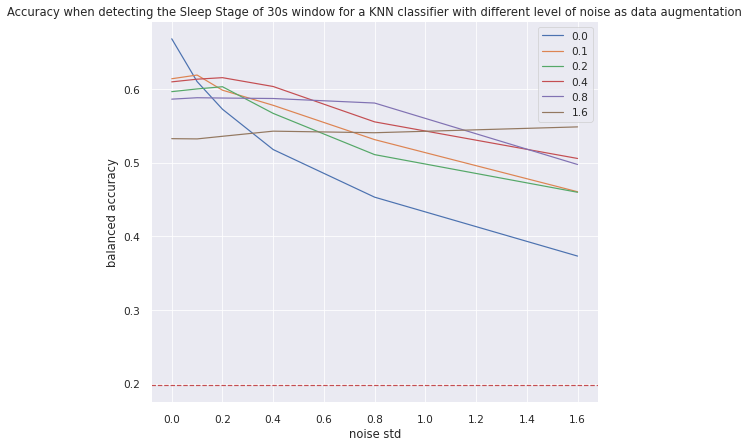

In [78]:
plot_knn_noise(noise_embds_list, sleep_stages, noise_embds_list, sleep_stages, noise_levels, percentage_train=0.3, colorbar=False, verbose=1)
plt.legend(noise_levels, loc='upper right')
plt.savefig('img/knn_benchmark_sleep_noise_noise_notrain.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title('Accuracy when detecting the Sleep Stage of 30s window for a KNN classifier with different level of noise as data augmentation');

In [79]:
train_noise_embds_list = []
for noise in noise_levels:
    mean = [0.,0.]
    cov = [[noise, 0.], [0., noise]]
    self_train_set.transform = make_random_gaussian(mean, cov, same=same)
    train_noise_embds_list.append([skorch_net.transform(self_train_set)[::2] for skorch_net in tqdm(skorch_nets)])
self_train_set.transform = None
train_noise_embds_list = np.array(train_noise_embds_list).transpose(1,0,2,3)

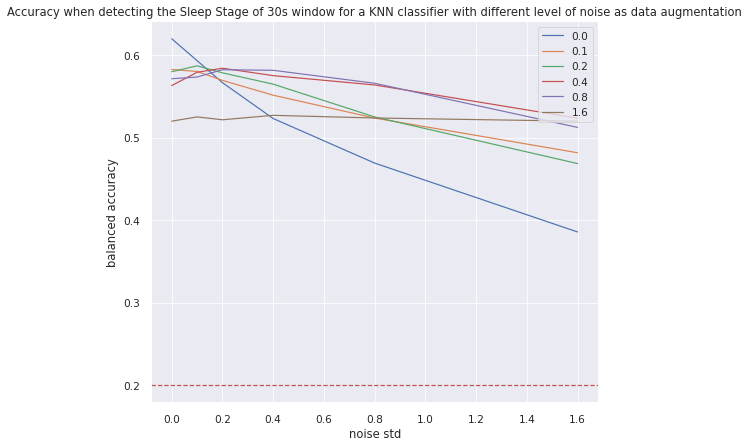

In [80]:
plot_knn_noise(train_noise_embds_list, train_sleep_stages, noise_embds_list, sleep_stages, noise_levels, percentage_train=0.3, colorbar=False, verbose=1)
plt.legend(noise_levels, loc='upper right')
plt.savefig('img/knn_benchmark_sleep_noise_noise_train.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title('Accuracy when detecting the Sleep Stage of 30s window for a KNN classifier with different level of noise as data augmentation');